# 프로젝트: CIFAR-10 이미지 생성하기
- GAN을 학습하는 과정은 보기보다 까다롭습니다:
  - 모델 구조
  - learning_rate
  - 파라미터 초기화
  - 생성자와 판별자의 경쟁 관계
  - 데이터의 특성 등 <br> 고려해야 할 것이 참 많습니다.

- 이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 <br> 
 **CIFAR-10 데이터를 생성하는 모델**을 직접 만들어 봅시다.
- 모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다:

  - 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 
    - 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
  - 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다.
    - 시각화 과정에서 고려할 점이 있습니다.
  - 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## STEP 0. 필요한 패키지 불러오기
- 라이브러리 설치 여부 확인하기
  - ☁️ Cloud Shell 에서 입력

  - \$ pip list | grep -E 'imageio|Pillow'

- imageio, pillow 라이브러리가 없을 경우 다음 설치:
  - \$ pip install imageio
  - \$ pip install Pillow

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 1. 작업환경 구성하기
다음과 같이 작업환경을 구성합시다:

- \$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
- \$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
- \$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기
- tf.keras 안에 있는 datasets에 포함

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

print("- 훈련용 데이터 크기:", train_x.shape)
print("- 테스트용 데이터 크기:", test_x.shape)

170508288/170498071 [==============================] - 4s 0us/step
- 훈련용 데이터 크기: (50000, 32, 32, 3)
- 테스트용 데이터 크기: (10000, 32, 32, 3)


- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.
- 학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행해도 좋습니다. 아래 코드는 참고만 하세요.

In [3]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(train_x, train_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

### 2-1. 훈련(학습)용 데이터 정규화
- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화

In [4]:
# 이미지 확인용으로 별도 저장
img_train_x = train_x
img_test_x = test_x

# 이미지를 [-1, 1]로 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("- max pixel:", train_x.max())
print("- min pixel:", train_x.min())

- max pixel: 1.0
- min pixel: -1.0


In [5]:
#train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
#train_x.shape
#print(train_x[0])

### 2-2. 훈련용 데이터 시각화
- 로드한 학습 데이터 시각화를 통해 확인

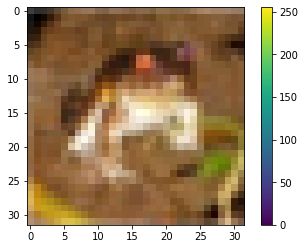

In [6]:
plt.imshow(img_train_x[0].reshape(32,32,3).astype('int32'))
plt.colorbar()
plt.show()

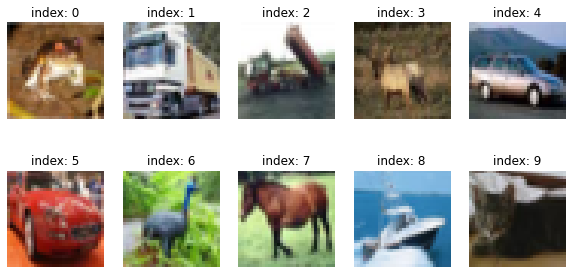

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img_train_x[i].reshape(32, 32, 3).astype('int32'))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

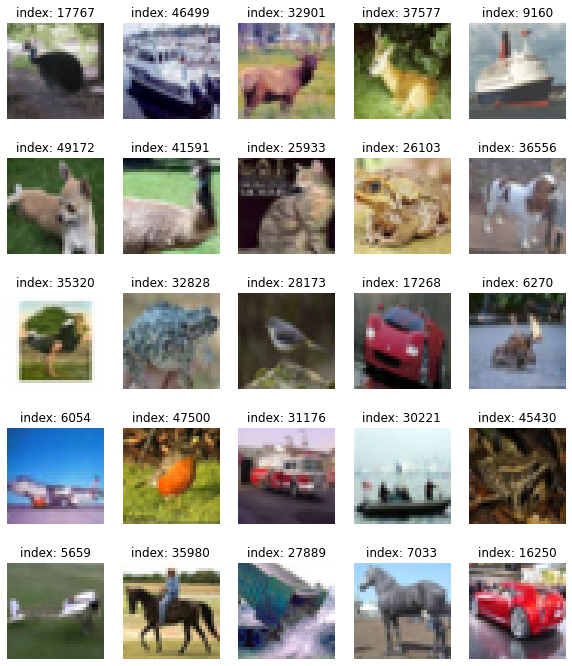

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(img_train_x[random_index].reshape(32,32,3).astype('int32'))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

### 2-3. TensorFlow Dataset을 활용한 훈련용 데이터셋 준비

In [9]:
BUFFER_SIZE = 50000 # 훈련용 데이터셋 크기와 동일하게 설정
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

### 3-1. 생성자모델 구현 (함수)
- (32, 32, 3) shape 이미지 생성

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    #model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape layer
    #model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer -> umsample to 16x16
    #model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer -> upsample to 32x32
    #model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.LeakyReLU(alpha=0.2))
      
    # Fifth: Conv2DTranspose layer -> output layer
    #model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', activation='tanh'))
    
    return model

- 생성모델(generator) 작성 및 모델 세부 내용 출력

In [12]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

> conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         4800   
- 최종 레이어에서 (32, 32, 3)의 shape를 가진 이미지가 생성됨을 알 수 있음

### 3-2. 입력 이미지 생성
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.

In [13]:
noise = tf.random.normal([1, 100]) # 차원 (1,100)으로 표준정규분포를 따르는 랜덤 넘버 생성
print(np.min(noise))
print(np.max(noise))

-3.2743125
2.2472444


In [14]:
generated_image = generator(noise, training=False) # "training=False"로 지정해야 훈련을 하지 않고 결과만 내줌(inference만 함)
print(generated_image.shape)
print(np.min(generated_image))
print(np.max(generated_image))

(1, 32, 32, 3)
-0.057485096
0.051406


- [1, 32, 32, 3] 사이즈의 이미지 생성되었음

#### [컬러 이미지 화면 출력을 위한 이미지 변환]
- 픽셀값 변환, 객체 타입 확인

In [15]:
# 최소값, 최대값 확인
print("- 생성된 랜덤 넘버 최소값:", np.min(generated_image))
print("- 생성된 랜덤 넘버 최대값:", np.max(generated_image))

# 픽셀값 [-1,1] → [0, 2] → [0, 255] 변환
generated_image_display = ((generated_image+1)/2)*255

# 최소값, 최대값 확인
print("\n- 변환 후 픽셀 최소값:", np.min(generated_image_display))
print("- 변환 후 픽셀 최대값:", np.max(generated_image_display))
print("- Shape:", generated_image_display.shape)

# 객체 type 확인
print("\n- 객체 generated_image_display의 타입:", type(generated_image_display))
print("- 객체 generated_image_display.numpy()의 타입:", type(generated_image_display.numpy()))

- 생성된 랜덤 넘버 최소값: -0.057485096
- 생성된 랜덤 넘버 최대값: 0.051406

- 변환 후 픽셀 최소값: 120.17065
- 변환 후 픽셀 최대값: 134.05428
- Shape: (1, 32, 32, 3)

- 객체 generated_image_display의 타입: <class 'tensorflow.python.framework.ops.EagerTensor'>
- 객체 generated_image_display.numpy()의 타입: <class 'numpy.ndarray'>


- -1과 1 사이의 값 (-0.074 ~ 0.057) 에서 적당히 잘 생성된 것을 확인할 수 있음
  - 컬러 이미지 출력을 위해 [0, 255] 사이의 값으로 변환한 결과 (118 ~ 135)값 생성

### 3-3. 입력 이미지 확인
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

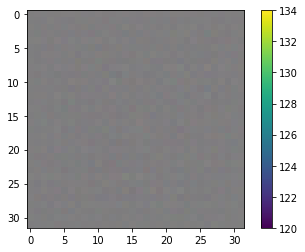

In [16]:
#plt.imshow(generated_image[0, :, :, 0])
plt.imshow(generated_image_display[0, :, :, :].numpy().astype('int32')) # 컬러로 display 하는 방법!!!
plt.colorbar()
plt.show()

- 아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지 생성

## STEP 4. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

### 4-1. 판별자모델 구현 (함수) - 변경
- (32, 32, 3) 이미지를 입력으로 받아  판별 결과를 출력

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer -> Normal
    # model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    # model.add(layers.LeakyReLU())
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer -> Downsample
    #model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))

    # (추가) downsample
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # (추가) downsample
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Flatten Layer -> classifier
    model.add(layers.Flatten())

    # Fourth: Dense Layer -> classifier
    model.add(layers.Dropout(0.4)) # 추가
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

- make_discriminator_model 함수로 구현
- 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나감
  - 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)로 줄어듬
- Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환
- 마지막 Dense Layer를 거쳐 단 하나의 값 출력

- 판별모델(discriminator) 작성 및 모델 세부 내용 출력

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)        

### 4-2. 생성 이미지에 대한 판별 결과 확인
- 앞에서 생성한 가짜 이미지를 판별자에 입력시켜 결과 확인

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4998732]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력 (-.0003...). 아직은 아무런 의미가 없음

## STEP 5. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### 5-1. 생성자/판별자 손실함수 구현

- 손실함수로 Crossentropy 사용. 이진분류이므로 BinaryCrossEntropy 사용
- tf.keras.losses의 BinaryCrossEntropy 클래스는 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정
  - from_logits를 True로 설정: BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output 두 가지를 활용
  - **fake_output**: 생성자가 생성한 Fake Image를 판별자에 입력시켜서 판별된 값, 즉 D(fake_image)
  - **real_output**: 기존에 있던 Real Image를 판별자에 입력시켜서 판별된 값, 즉 D(real_image)

#### 5-1-1. 생성자 손실함수 구현

- 생성자 손실함수 generator_loss
  - generator_loss는 fake_output값이 1에 가까워지기를 바라므로, tf.ones_like와의 교차 엔트로피값 계산
  - cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 5-1-2. 판별자 손실함수 구현

- 판별자 손실함수 discriminator_loss
  - discriminator_loss는 real_output값은 1에, fake_output값은 0에 가까워지기를 바라므로, 두 가지 loss값 모두 계산
    - real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교
  - 최종 discriminator_loss 값은 이 둘을 더한 값

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 5-2. 판별자 정확도 계산 함수 구현

- 판별자 정확도 discriminator accuracy
  - 판별자가 real output 판별 정확도(real_accuracy), fake output 판별 정확도(fake_accuracy)를 따로 계산해서 비교
  - real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적
  - fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- 사용된 tensorflow 함수들 설명: (예) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,
  - (1) tf.math.greater_equal(real_output, tf.constant([0.5]): real_output의 각 원소가 0.5 이상인지 True, False로 판별 → tf.Tensor([False, False, True, True])
  - (2) tf.cast( (1), tf.float32): (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 → tf.Tensor([0.0, 0.0, 1.0, 1.0])
  - (3) tf.reduce_mean((2)): (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 → 0.5

### 5-3. 최적화기법 (optimizer) 설정
- Adam 최적화기법 활용
  - learning rate는 0.0001로 설정: 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것 추천
- 생성자와 구분자는 별도 네트워크이므로 optimizer를 각각 설정

In [24]:
learning_rate = 0.0001

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)

#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


### 5-4. 훈련(학습) 진도 파악용 입력 이미지 (seed) 생성
- 입력 이미지(샘플)는 한 번에 16장 생성
- 생성자 진전 과정을 확인을 위해 고정된 seed 노이즈 생성
  - 100차원 노이즈 총 16개, (16, 100) 형상의 벡터 생성

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

### 6-1. 한 단계(미니배치 한 개) 훈련 함수

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- train_step 함수 설명:
  - (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
  - (2) 생성자 입력 노이즈: generator가 FAKE IMAGE를 생성하기 위한 noise를 image 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성
  - (3) tf.GradientTape(): 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
  - (4) generator image 생성: generator가 noise를 입력받은 후 generated_images 생성
  - (5) discriminator 판별: discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
  - (6) loss 계산: fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
  - (7) accuracy 계산: fake_output, real_output으로 discriminator의 정확도 계산
  - (8) gradient 계산: gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
  - (9) 모델 학습: 계산된 gradient를 optimizer에 입력해 가중치 갱신
  - (10) 리턴값: 이번 스텝에 계산된 loss와 accuracy를 리턴

### 6-2. 훈련 현황 파악용 샘플 이미지 생성 및 저장 함수

- train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
- 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지 확인

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    # 컬러 이미지 출력을 위한 변환
    predictions_display = ((predictions+1)/2)*255 # 픽셀값 [-1,1] → [0, 2] → [0, 255] 변환
   
    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0], cmap='gray') # 흑백 이미지 출력
        plt.imshow(predictions_display[i, :, :, :].numpy().astype('int32')) # 컬러로 display 하는 방법!!!
        plt.axis('off')
   
    #plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
    #                .format(os.getenv('HOME'), epoch, it))
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    
    plt.show()
    

- 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화
- plt에 저장되어 보이는 이미지를 plt.savefig로 파일로 저장

### 6-3. 훈련(학습) 과정 시각화 함수: Loss, Accuracy

- train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장
- 매 epoch마다 시각화하는 함수
  - (예) 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10  # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    #plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
    #                .format(os.getenv('HOME'), epoch))
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()
    

### 6-4. 정기적 모델 저장을 위한 CheckPoint 생성

- checkpoint에는 optimizer, 생성자와 판별자가 학습한 모델 가중치 등 학습 환경과 학습한 내용 저장
- checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints라는 디렉토리 사용

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

- 모델 학습 함수(train) 정의

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

#### [train 함수 내용]
- start 시간 기록  
- history 초기화  
- 각 epoch에 대하여 (*for epoch in range(epochs):*)    
  - 시각 기록
  - 각 훈련데이터(image_batch)에 대해 (*for it, image_batch in enumerate(dataset):*)
    - 한 단계 훈련(train_step) 실행
    - 매 50번 마다 (*if it % 50 == 0:*)
      - 이미지 지워주고
      - 샘플 이미지 생성 & 저장
      - epoch#, iteration#, 시각 찍고
  - save_every 마다 (*if (epoch + 1) % save_every == 0:*)
    - checkpoint.save
  - 이미지 지워주고, 샘플 이미지 생성 & 저장, epoch#, iteration#, 시각 찍고
  - 학습과정 시각화
  - epoch 하나 완료


- 출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정해서 마음에 드는 형태로 확인해 보세요!

- 본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있습니다.
  - RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면,
  <br> 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 
  <br> 최대한 GPU 환경에서 실습해 보는 것을 추천합니다.

In [32]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- train() 함수 실행
  - 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인 가능


<span style="color:green; font-weight:bold; font-size:20px"> (훈련 재개 포인트) 두 번째 실행은 여기부터! </span>

### 7-1. CheckPoint 모듈 활용 모델 로드 (첫 번째 실행에서는 제외)
- (참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. <br> 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
  - 우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. <br> 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
  - 아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

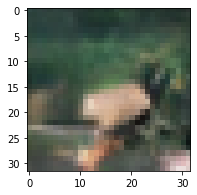

In [41]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(3, 3))

plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [42]:
save_every = 10 # 모델 저장 간격
EPOCHS = 100 # 전체 학습 에포크

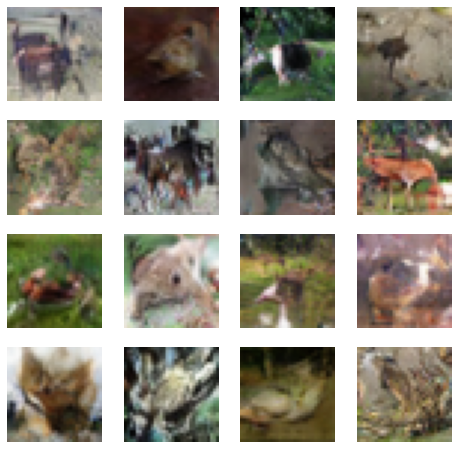

Time for training : 3410 sec


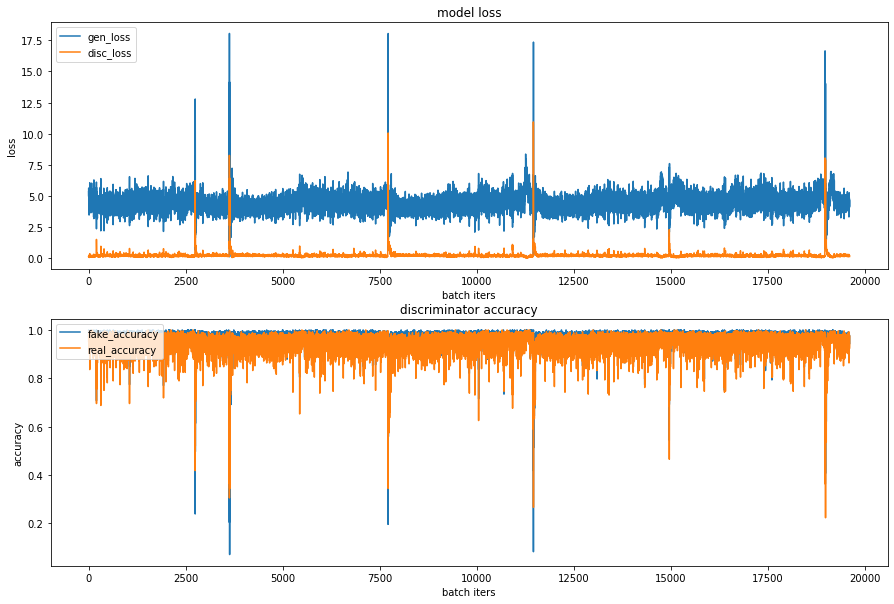

CPU times: user 57min 39s, sys: 2min 41s, total: 1h 21s
Wall time: 56min 52s


In [43]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

- 훈련 결과 확인...
  - **Discriminator fake_accuracy**(생성자가 만든 Fake Image에 대한 판별자의 Accuracy)가 0.5가 되는 것이 이상적
    - 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻
<br> <br>
- 보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다.
- 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!
- 과연 생성 모델이 이전에는 없던 새로운 디자인의 패션을 만들어내는 것을 확인할 수 있을 거예요..!
  <br> (물론 시간은 그와 비례하게 늘어나겠죠..?)
<br> <br>
- 어쩌면 단순히 학습 수행 시간만 늘리는 것보다, 모델 구조나 학습 방법을 바꾸어 봐야 할 수도 있습니다.
- 그래프를 유심히 보면서 학습 결과가 더 이상 개선되고 있지 않은지 여부를 지속적으로 살펴봅시다.

### 7-2. 학습과정 gif 파일 만들기
- 학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일(움짤)로 만들기
- GIF 파일은 import 해놓았던 imageio 라이브러리를 활용해 생성
  - imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식
  - cifar10_dcgan.gif 파일로 저장

In [44]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 4092994 Feb 13 11:30 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


- cloud jupyter를 열고 ~/aiffel/dcgan_newimage/cifar10/ 폴더에서 cifar10_dcgan.gif를 클릭, 확인 후...

<span style="color:red; font-weight:bold; font-size:20px"> cifar10_dcgan.gif 파일 이름 변경 후 훈련 재개! 😄</span>


<span style="color:green; font-weight:bold; font-size:20px"> (훈련 재개 포인트)로 돌아가기! </span>

## STEP 8. (optional) GAN 훈련 과정 개선하기
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.
<br> <br>
- (참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

    - [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
    - [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
    - [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
    > The tips draw upon the suggestions from the DCGAN paper as well as elsewhere. <br> A summary of some of the more actionable tips is provided below.

      > - Normalize inputs to the range [-1, 1] and use tanh in the generator output.
      > - Flip the labels and loss function when training the generator.
      > - Sample Gaussian random numbers as input to the generator.
      > - Use mini batches of all real or all fake for calculating batch norm statistics.
      > - Use Leaky ReLU in the generator and discriminator.
      > - Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.
      > - Use label smoothing in the discriminator, with small random noise.
      > - Add random noise to the labels in the discriminator.
      > - Use DCGAN architecture, unless you have a good reason not to.
      > - A loss of 0.0 in the discriminator is a failure mode.
      > - If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.
      > - Use labels if you have them.
      > - Add noise to inputs to the discriminator and decay the noise over time.
      > - Use dropout of 50 percent during train and generation.
    
    - [Improved Techniques for Training GANs(paper)](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)


## 프로젝트 평가

| 평가문항 | 상세기준 | 실행 결과 |
|:---|:---|:---:|
| 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. | 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다. | 생성 했음 |
| 2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 <br> 진행되었음을 입증하였다. | gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 <br> 추세적으로 0.5를 향해 하향하고 있음을 확인하였다. | gif로 확인 했음. <br> 샘플 이미지 비교로도 <br> 확인 가능 |
| 3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 <br> 제안하고 이를 적용하였다. | 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 <br> 이전보다 향상되었음을 시각적으로 입증하였다. | 확인 했음 |



## 프로젝트 코드 순서

- STEP 0. 필요한 패키지 불러오기
- STEP 1. 작업환경 구성하기
- STEP 2. 데이터셋 구성하기
  - 2-1. 훈련(학습)용 데이터 정규화
  - 2-2. 훈련용 데이터 시각화
  - 2-3. TensorFlow Dataset을 활용한 훈련용 데이터셋 준비
- STEP 3. 생성자 모델 구현하기
  - 3-1. 생성자모델 구현 (함수)
  - 3-2. 입력 이미지 생성
  - 3-3. 입력 이미지 확인
- STEP 4. 판별자 모델 구현하기
  - 4-1. 판별자모델 구현 (함수)
  - 4-2. 생성 이미지에 대한 판별 결과 확인
- STEP 5. 손실함수와 최적화 함수 구현하기
  - 5-1. 생성자/판별자 손실함수 구현
    - 5-1-1. 생성자 손실함수 구현
    - 5-1-2. 판별자 손실함수 구현
  - 5-2. 판별자 정확도 계산 함수 구현
  - 5-3. 최적화기법 (optimizer) 설정
  - 5-4. 훈련(학습) 진도 파악용 입력 이미지 (seed) 생성
- STEP 6. 훈련과정 상세 기능 구현하기
  - 6-1. 한 단계(미니배치 한 개) 훈련 함수
  - 6-2. 훈련 현황 파악용 샘플 이미지 생성 및 저장 함수
  - 6-3. 훈련(학습) 과정 시각화 함수: Loss, Accuracy
  - 6-4. 정기적 모델 저장을 위한 CheckPoint 생성
- STEP 7. 학습 과정 진행하기
  - 7-1. CheckPoint 모듈 활용 모델 로드 (첫 번째 실행에서는 제외)
  - 7-2. 학습과정 gif 파일 만들기
- STEP 8. (optional) GAN 훈련 과정 개선하기

## (optional) GAN 훈련 과정 개선 시도
- 아래 사이트를 참고하여 모델 구조 변경:
  - (3-1 부분) Generator 모델 변경
    - kernel 사이즈 변경, stride 변경, Batch Normalization 제거, 네 번째 층 필터 수 변경 등
  - (4-1 부분) Discriminator 모델 변경
    - kernel 사이즈 변경, downsample층 두 개 추가, Clssifier에 Dropout 추가 등
  - (5-3 부분) Discriminator Optimizer 파라미터 변경
    - Adam의 파라미터 learning_rate=0.0002, beta_1=0.5 지정
<br> <br>
- (참고) [How to Develop a GAN to Generate CIFAR10 Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

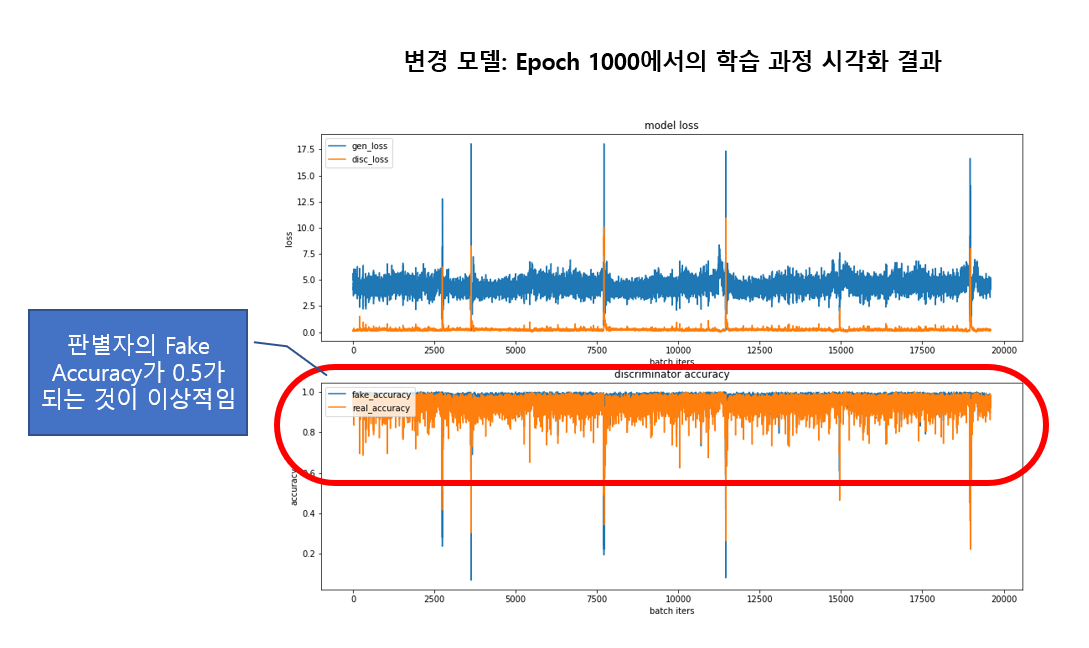

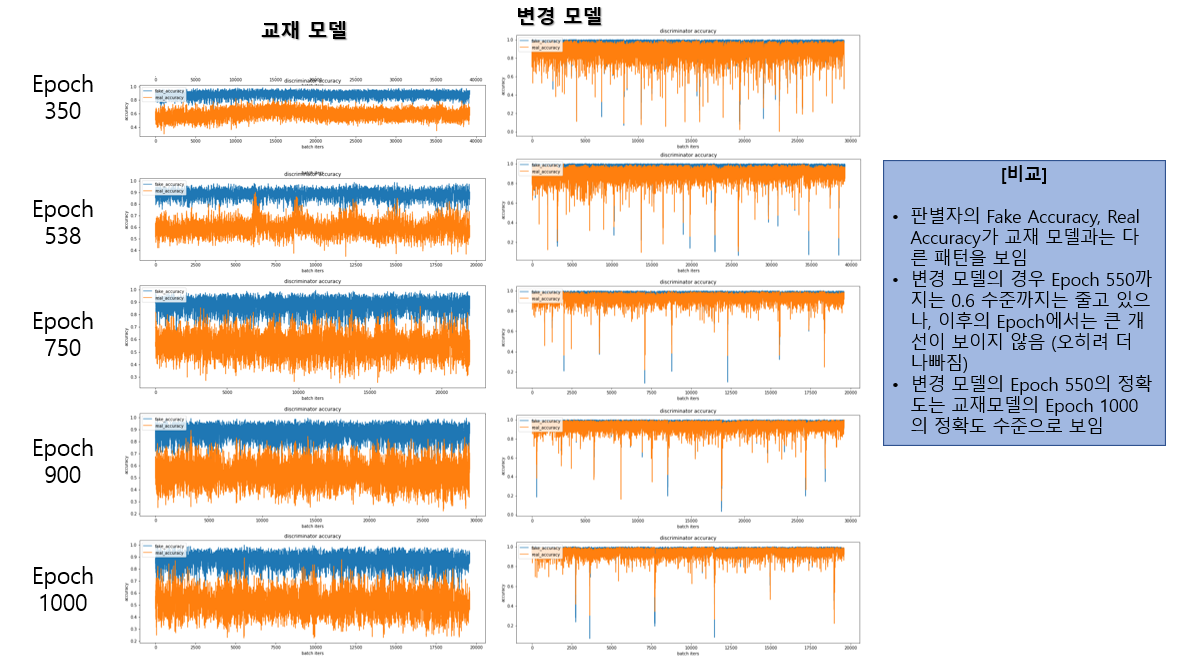

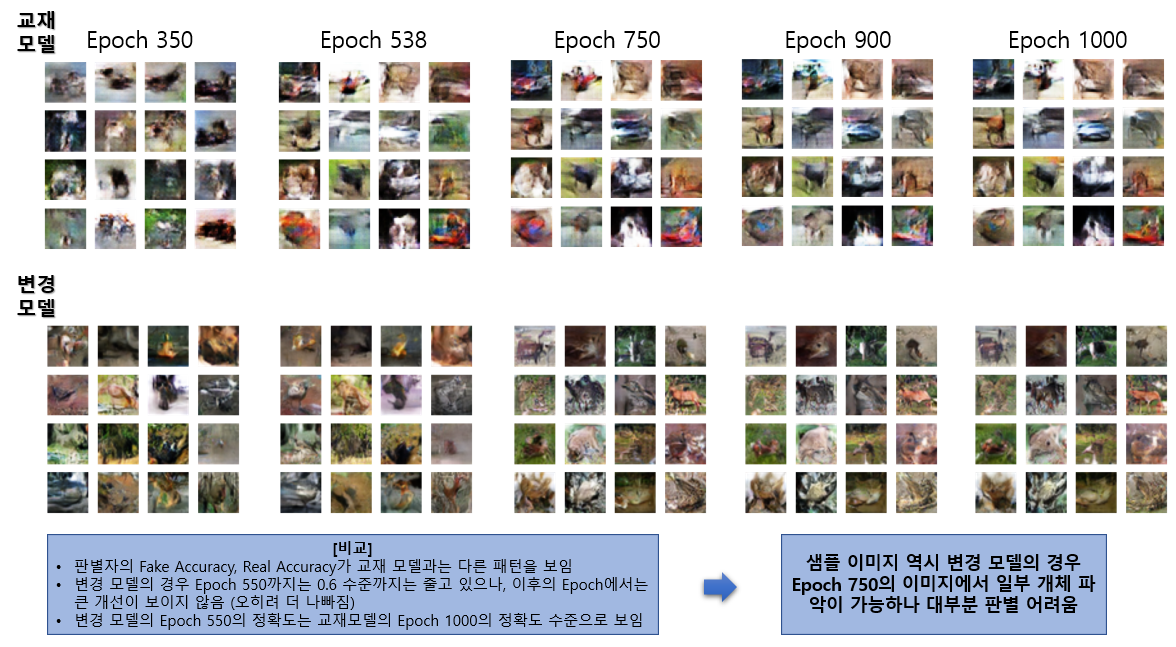

### 결과 분석

- 선명한 샘플 이미지를 얻기 위해 모델 변경을 해서 실행해 보았음
- 변경 모델의 판별자 Fake Accuracy 개선 속도가 빠른 것으로 보임
- 그러나 이상적 수치인 0.5에는 다다르지 못하며, 0.7 수준에 다다른 후 더 나빠지는 모습을 보임
- 최선의 판별자 Fake Accuracy는 대략 0.7 수준으로 교재 모델, 변경 모델 모두에서 비슷하며
- 이에 도착하는 속도는 변경 모델이 다소 빠른 것으로 보임
- 결과 이미지는 보이는 바와 같이 일부 식별 가능한 객체가 있긴 하나, 대부분 식별이 어려움

### 회고
- DCGAN 모델을 실행해 보았다는 의미가 있음
- 결과는 별로임 (기대가 너무 컸나 봄)
- GIF를 만들 때 Epoch별로 만들지 않고 Epoch 전체에서 만들어지는 샘플 이미지들을 모두 모아서 만들면 더 좋을 듯
  - 프로그램을 약간 변경하면 가능하겠음
- 한 번의 실행 후 결과 파일들을 다른 폴더로 옮기고 해야 하는데 뒤 늦게 파악함
- 클라우드 주피터에서 파일을 로컬로 다운로드함에 있어서 파일 하나하나 할 수 밖에 없는지???
  - 클라우드 쉘에서 리눅스 명령어를 쓰면 한번에 가능한지???
- 개선안을 찾는 것은 쉬운 일이 아님
- ... (to be continued~) ... Exploration 11로...